# Lab.5.3.1.manuf1 - Products Defect Detection in Production Line using SageMaker TensorFlow Object Detection


---

In this notebook, we practice training a CV model for product defect detection running on a production line. This helps to identify manufacturing product defects. Using such reproducible and automated mechanism allows you to increase the number of quality checks along the production line, leading to improved inspection tasks, reduced errors and more visibility into the manufacturing chain. This helps to better understand your manufacturing processes and obtain insights on how to improve them using a data driven approach.

To train the model, we demonstrate how to use the TensorFlow Object Detection algorithm. Object Detection refers to predicting the objects in an image via bounding boxes. To train efficiently, we explore how to fine-tune a pre-trained model to a custom dataset, and then run inference on the fine-tuned model.

Note: This notebook was tested on ml.t3.medium instance in Amazon SageMaker Studio with Python 3 (Data Science) kernel and in Amazon SageMaker Notebook instance with conda_python3 kernel.

---

1. [Set Up](#1.-Set-Up)
2. [Select a pre-trained model](#2.-Select-a-pre-trained-model)
<!-- 3. [Run inference on the pre-trained model](#3.-Run-inference-on-the-pre-trained-model)
    * [Retrieve Artifacts & Deploy an Endpoint](#3.1.-Retrieve-Artifacts-&-Deploy-an-Endpoint)
    * [Download example images for inference](#3.2.-Download-example-images-for-inference)
    * [Query endpoint and parse response](#3.3.-Query-endpoint-and-parse-response)
    * [Display Model Predictions](#3.4.-Display-Model-Predictions)
    * [Clean up the endpoint](#3.5.-Clean-up-the-endpoint) -->
3. [Fine-tune the pre-trained model on a custom dataset](#4.-Fine-tune-the-pre-trained-model-on-a-custome-dataset)
    * [Retrieve Training artifacts](#4.1.-Retrieve-Training-artifacts)
    * [Set Training parameters](#4.2.-Set-Training-parameters)
    * [Train with Automatic Model Tuning (HPO)](#AMT)
    * [Start Training](#4.4.-Start-Training)
    * [Extract Training performance metrics](#4.5.-Extract-Training-performance-metrics)
    * [Deploy & run Inference on the fine-tuned model](#4.6.-Deploy-&-run-Inference-on-the-fine-tuned-model)
    * [Incrementally train the fine-tuned model](#4.7.-Incrementally-train-the-fine-tuned-model)

## 1. Set Up
***
Before executing the notebook, there are some initial steps required for setup. This notebook requires latest version of sagemaker.
***

In [10]:
# !pip install sagemaker ipywidgets --upgrade --quiet
!pip install -U sagemaker imageio --quiet

You should consider upgrading via the '/usr/local/bin/python3.6 -m pip install --upgrade pip' command.


---

To train and host on Amazon Sagemaker, we need to setup and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook instance as the AWS account role with SageMaker access. It has necessary permissions, including access to your data in S3. 

---

In [1]:
import os
import numpy as np
import sagemaker, boto3, json
from sagemaker.session import Session

sagemaker_session = Session()
account_id = sagemaker_session.account_id()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

Couldn't call 'get_role' to get Role ARN from role name hekal to get Role path.


## 2. Prepare dataset

To prepare the training data in the expected format, we need to read the manifest file produced by the SageMaker Ground Truth annotation job and convert it to the COCO annotation format.

### Split into train and validation datasets

In [3]:
def read_manifest_file(file_path):
    """Load manifest file."""
    with open(file_path, 'r') as f:
        output = [json.loads(line.strip()) for line in f.readlines()]
        return output


def train_validation_split(labels, split_factor=0.9):
    """Split manifest file into a train and validation parts."""
    np.random.shuffle(labels)

    dataset_size = len(labels)
    train_test_split_index = round(dataset_size*split_factor)

    train_data = labels[:train_test_split_index]
    validation_data = labels[train_test_split_index:]
    return train_data, validation_data

### Data augmentation


TODO: replace the following code to use https://github.com/albumentations-team/albumentations/ instead. 
Perform data augmentation on the train dataset.

In [16]:
TMP_FOLDER_NAME = "tmp"
!mkdir -p {TMP_FOLDER_NAME}

In [17]:
%run utils/flip_images.py -m s3://{BUCKET_NAME}/{PREFIX}/{JOB_NAME}/manifests/output/output.manifest -d {TMP_FOLDER_NAME} -b {BUCKET_NAME} -p coco-format/images

INFO:__main__:working directory: tmp


100


In [18]:
%run utils/flip_annotations.py -m s3://{BUCKET_NAME}/{PREFIX}/{JOB_NAME}/manifests/output/output.manifest -d {TMP_FOLDER_NAME} -p {JOB_NAME}

INFO:__main__:working directory: tmp
INFO:__main__:wrote 100 lines to tmp/x-flipped.json
INFO:__main__:uploaded tmp/x-flipped.json to s3://sagemaker-cv-bootcamp-us-east-1-<AWS_ACCOUNT_ID>/cv-bootcamp-manuf-at-scale-cap-no-cap


100


INFO:__main__:wrote 100 lines to tmp/y-flipped.json
INFO:__main__:uploaded tmp/y-flipped.json to s3://sagemaker-cv-bootcamp-us-east-1-<AWS_ACCOUNT_ID>/cv-bootcamp-manuf-at-scale-cap-no-cap
INFO:__main__:wrote 100 lines to tmp/ccw_rotated.json
INFO:__main__:uploaded tmp/ccw_rotated.json to s3://sagemaker-cv-bootcamp-us-east-1-<AWS_ACCOUNT_ID>/cv-bootcamp-manuf-at-scale-cap-no-cap
INFO:__main__:wrote 100 lines to tmp/cw_rotated.json
INFO:__main__:uploaded tmp/cw_rotated.json to s3://sagemaker-cv-bootcamp-us-east-1-<AWS_ACCOUNT_ID>/cv-bootcamp-manuf-at-scale-cap-no-cap
INFO:__main__:wrote 500 lines to tmp/all_augmented.json
INFO:__main__:uploaded tmp/all_augmented.json to s3://sagemaker-cv-bootcamp-us-east-1-<AWS_ACCOUNT_ID>/cv-bootcamp-manuf-at-scale-cap-no-cap


### Convert annotations from SageMaker Ground Truth format to COCO format 

In [19]:
categories = [
    {"id": 0, "name": "cap"},
    {"id": 1, "name": "no-cap"}
]

In [43]:
def grouth_truth_manifest_to_tf_object_detection_annotations(
        ground_truth_manifest, categories
    ):
    images = []
    annotations = []
    for idx, annotation in enumerate(ground_truth_manifest):
        curr_img = {}
        curr_img["id"] = idx
        curr_img["file_name"] = annotation['image_path'].split("/")[-1]
        curr_img.update({"height": 1944, "width": 2592})
        images.append(curr_img)
#         image_size = annotation[annotation_job_name]["image_size"][0]
        width, height = 2592, 1944   #image_size["width"], image_size["height"]
        for _annotation in annotation['annotation']:
            curr_annotation = {}
            curr_annotation["image_id"] = idx
            curr_annotation["category_id"] = _annotation["class_id"]
            curr_annotation["bbox"] = convert_bbox_from_gt_to_coco(_annotation, width, height)
            annotations.append(curr_annotation)

    return {
        "images": images,
        "annotations": annotations,
        "categories": categories
    }

grouth_truth_manifest_to_tf_object_detection_annotations(data,{1:'sss',2:'dafasf'})

KeyError: 'image_path'

Convert the training and validation dataset into the COCO format and organize the data as expected by the SageMaker TensorFlow Object Detection API.

In [44]:
categ = {0: 'Milk', 1: 'Mint', 2: 'Tea', 3: 'Green Tea', 4: 'Nescafe', 5: 'Gold'}

In [46]:
data = read_manifest_file('/home/hekal/Downloads/annotations.json')
coco_data = grouth_truth_manifest_to_tf_object_detection_annotations(data,categories=categ)

In [47]:
coco_data

{'images': [{'id': 0, 'file_name': '27.jpg', 'height': 1944, 'width': 2592},
  {'id': 1, 'file_name': '36.jpg', 'height': 1944, 'width': 2592},
  {'id': 2, 'file_name': '17.jpg', 'height': 1944, 'width': 2592},
  {'id': 3, 'file_name': '46.jpg', 'height': 1944, 'width': 2592},
  {'id': 4, 'file_name': '37.jpg', 'height': 1944, 'width': 2592},
  {'id': 5, 'file_name': '29.jpg', 'height': 1944, 'width': 2592},
  {'id': 6, 'file_name': '13.jpg', 'height': 1944, 'width': 2592},
  {'id': 7, 'file_name': '40.jpg', 'height': 1944, 'width': 2592},
  {'id': 8, 'file_name': '14.jpg', 'height': 1944, 'width': 2592},
  {'id': 9, 'file_name': '47.jpg', 'height': 1944, 'width': 2592},
  {'id': 10, 'file_name': '30.jpg', 'height': 1944, 'width': 2592},
  {'id': 11, 'file_name': '2.jpg', 'height': 1944, 'width': 2592},
  {'id': 12, 'file_name': '21.jpg', 'height': 1944, 'width': 2592},
  {'id': 13, 'file_name': '26.jpg', 'height': 1944, 'width': 2592},
  {'id': 14, 'file_name': '35.jpg', 'height': 194

In [39]:
augmented_data_path = "tmp/all_augmented.json"
augmented_data = read_manifest_file(augmented_data_path)

data_tf_od_annotations = grouth_truth_manifest_to_tf_object_detection_annotations(
    augmented_data, categories, annotation_job_name='cap-no-cap'
)

# validation_data_tf_od_annotations = grouth_truth_manifest_to_tf_object_detection_annotations(
#     validation_data, categories, annotation_job_name='cap-no-cap'
# )

In [40]:
augmented_data[0]

{'source-ref': 's3://sagemaker-cv-bootcamp-us-east-1-<AWS_ACCOUNT_ID>/raw-data/manufacturing-at-scale-cap-no-cap/guvcview_image-100.jpg',
 'cap-no-cap': {'image_size': [{'width': 640, 'height': 480, 'depth': 3}],
  'annotations': [{'class_id': 0,
    'top': 180,
    'left': 276,
    'height': 112,
    'width': 120}]},
 'cap-no-cap-metadata': {'objects': [{'confidence': 0}],
  'class-map': {'0': 'cap'},
  'type': 'groundtruth/object-detection',
  'human-annotated': 'yes',
  'creation-date': '2022-11-22T08:35:18.167234',
  'job-name': 'labeling-job/cv-bootcamp-manuf-at-scale-cap-no-cap'}}

In [38]:
data = read_manifest_file('../../../../output (2).manifest')
data[0]['supermarket-dataset']['image_size']

[{'width': 2592, 'height': 1944, 'depth': 3}]

In [41]:
len(data_tf_od_annotations['images']), len(data_tf_od_annotations['annotations'])

(500, 500)

In [42]:
write_coco_annotations(data_tf_od_annotations, "tmp/coco_annotations.json")

## 3. Select a pre-trained model
***
You can continue with the default pretrained model defined below or choose a different one. A complete list of SageMaker pre-trained models can also be accessed at [Sagemaker pre-trained Models](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html#).
***

In [26]:
# model_id, model_version = "tensorflow-od1-ssd-resnet50-v1-fpn-640x640-coco17-tpu-8", "*"
model_id, model_version = "tensorflow-od1-ssd-mobilenet-v2-fpnlite-640x640-coco17-tpu-8", "*"

## 4. Fine-tune the pre-trained model on a custom dataset
***

Here we discuss how a model can be finetuned to a custom dataset with any number of classes.

Transfer learning algorithm removes the object detection head of the pre-trained model and attaches a new randomly initialized head with number of classes same as the custom dataset. The fine-tuning step fine-tunes the last layer parameters while keeping the parameters of the rest of the model frozen, and returns the fine-tuned model. The objective during finetuning is to minimize box prediction error on the input data.

- **Input** – A directory with sub-directory images and a file annotations.json.

- **Output** – A fine-tuned model that can be deployed for inference or can be further trained using incremental training. A file mapping class indexes to class labels is saved along with the models.

The input directory should look like below if the training data contains two images. The names of .png files can be anything.

The s3 path should look like `s3://bucket_name/input_directory/`. Note the trailing `/` is required.

    input_directory
        |--images
            |--abc.png
            |--def.png
        |--annotations.json

The annotations.json file should have information for bounding_boxes and their class labels. It should have a dictionary with keys "images" and "annotations". Value for the "images" key should be a list of entries, one for each image of the form {"file_name": image_name, "height": height, "width": width, "id": image_id}. Value of the 'annotations' key should be a list of entries, one for each bounding box of the form {"image_id": image_id, "bbox": [xmin, ymin, xmax, ymax], "category_id": bbox_label}.

We provide pennfudanped dataset as a default dataset for fine-tuning the model. PennFudanPed comprises images of pedestrians. The dataset has been downloaded from here.

Citation: @ONLINE {pennfudanped, author = "Liming Wang1, Jianbo Shi2, Gang Song2, and I-fan Shen1", title = "Penn-Fudan Database for Pedestrian Detection and Segmentation", year = "2007", url = "https://www.cis.upenn.edu/~jshi/ped_html/" }

***

To use the annotated cap-no-cap dataset above, we need to put in the S3 in the expected folder structure.

In [27]:
s3_data_base_path = f"s3://{BUCKET_NAME}/{PREFIX}"
!aws s3 cp {s3_data_base_path}/ s3://{BUCKET_NAME}/coco-format/images/ --recursive --exclude "*.manifest" --exclude "coco-format/*" --exclude "cv-bootcamp-manuf-at-scale-cap-no-cap/*" --quiet
# !aws s3 cp s3://{BUCKET_NAME}/frames/ {s3_data_base_path}/coco-format/images/ --recursive --exclude "*.manifest" --quiet
!aws s3 cp tmp/coco_annotations.json s3://{BUCKET_NAME}/coco-format/annotations.json

NameError: name 'BUCKET_NAME' is not defined

In [28]:
# !aws s3 rm s3://{BUCKET_NAME}/coco-format/images/ --recursive --quiet

In [29]:
!aws s3 ls s3://{BUCKET_NAME}/coco-format/


Parameter validation failed:
Invalid bucket name "{BUCKET_NAME}": Bucket name must match the regex "^[a-zA-Z0-9.\-_]{1,255}$" or be an ARN matching the regex "^arn:(aws).*:(s3|s3-object-lambda):[a-z\-0-9]*:[0-9]{12}:accesspoint[/:][a-zA-Z0-9\-.]{1,63}$|^arn:(aws).*:s3-outposts:[a-z\-0-9]+:[0-9]{12}:outpost[/:][a-zA-Z0-9\-]{1,63}[/:]accesspoint[/:][a-zA-Z0-9\-]{1,63}$"


### 4.1. Retrieve Training artifacts
***
Here, for the selected model, we retrieve the training docker container, the training algorithm source, the pre-trained base model, and a python dictionary of the training hyper-parameters that the algorithm accepts with their default values. Note that the model_version="*" fetches the latest model. Also, we do need to specify the training_instance_type to fetch train_image_uri.
***

In [31]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters

training_instance_type = "ml.p3.2xlarge"

print(model_id, model_version)

# model version can be found in
# https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html
# available images: https://github.com/aws/deep-learning-containers/blob/master/available_images.md

# # Retrieve the docker image
# train_image_uri_1 = image_uris.retrieve(
#     region='us-east-1',
#     framework=None,
#     model_id=model_id,
#     model_version="*",
#     image_scope="training"
# )

train_image_uri = '763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-training:2.9-gpu-py39'

# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="training"
)
print(train_source_uri)
print(train_image_uri_1)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="training"
)


tensorflow-od1-ssd-mobilenet-v2-fpnlite-640x640-coco17-tpu-8 *


ValueError: Empty SageMaker instance type. For options, see: https://aws.amazon.com/sagemaker/pricing/instance-types

In [48]:
!aws s3 cp s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/tensorflow/transfer_learning/od1/v1.0.1/sourcedir.tar.gz tmp/

download: s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/tensorflow/transfer_learning/od1/v1.0.1/sourcedir.tar.gz to tmp/sourcedir.tar.gz


In [49]:
!mkdir -p tmp/source/
!tar xf tmp/sourcedir.tar.gz -C tmp/source/

In [50]:
ls tmp/source/

artifact_generation.py  extra_requirements.txt  train.py              version
constants/              lib/                    transfer_learning.py
dataset.py              model.py                utils.py
early_stopping.py       optimizer.py            validation.py


In [51]:
# cat /usr/local/lib/python3.9/site-packages/sagemaker/image_uri_config/tensorflow.json

In [52]:
# from https://github.com/aws/sagemaker-python-sdk/blob/483665a21a1cba353203e48e3aa0ede8e0538044/src/sagemaker/jumpstart/utils.py#L334
# from sagemaker.jumpstart import accessors

# res = accessors.JumpStartModelsAccessor.get_model_specs(
#         region="us-east-1", model_id=model_id, version="1.0.2"  # type: ignore
# )

# res.training_ecr_specs

In [53]:
# res.to_json()

### 4.2. Set Training parameters
***
Now that we are done with all the setup that is needed, we are ready to fine-tune our Object Detection model. To begin, let us create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job. 

There are two kinds of parameters that need to be set for training. 

The first one are the parameters for the training job. These include: (i) Training data path. This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training. Typically, we use GPU instances for these training. We defined the training instance type above to fetch the correct train_image_uri. 

The second set of parameters are algorithm specific training hyper-parameters.
***

In [54]:
# Sample training data is available in this bucket
training_data_bucket = BUCKET_NAME
training_data_prefix = "coco-format"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

output_bucket = sess.default_bucket()
output_prefix = "cv-bootcamp-cap-no-cap-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

In [55]:
!aws s3 ls {training_dataset_s3_path}

                           PRE coco-format/


***
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values.
***

In [112]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(model_id=model_id, model_version=model_version)

# [Optional] Override default hyperparameters with custom values
hyperparameters["epochs"] = "10"
hyperparameters["learning_rate"] = "0.01"
hyperparameters["batch_size"] = "3"
# hyperparameters["optimizer"] = "adam"
hyperparameters["train_only_top_layer"] = "True"
hyperparameters["reinitialize_top_layer"] = "True"

print(hyperparameters)

{'batch_size': '3', 'reinitialize_top_layer': 'True', 'train_only_top_layer': 'True', 'optimizer': 'adam', 'learning_rate': '0.01', 'beta_1': '0.9', 'beta_2': '0.999', 'momentum': '0.9', 'epsilon': '1e-07', 'rho': '0.95', 'initial_accumulator_value': '0.1', 'early_stopping': 'False', 'early_stopping_patience': '5', 'early_stopping_min_delta': '0.0', 'epochs': '10'}


### 4.3. Train with Automatic Model Tuning ([HPO](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html)) <a id='AMT'></a>
***
Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose. We will use a [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html) object to interact with Amazon SageMaker hyperparameter tuning APIs.
***

In [113]:
from sagemaker.tuner import ContinuousParameter

# Use AMT for tuning and selecting the best model
use_amt = False

# Define objective metric per framework, based on which the best model will be selected.
amt_metric_definitions = {
    "metrics": [{"Name": "validation:localization_loss", "Regex": "Val_localization=([0-9\\.]+)"}],
    "type": "Minimize",
}

# You can select from the hyperparameters supported by the model, and configure ranges of values to be searched for training the optimal model.(https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-define-ranges.html)
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.5, scaling_type="Logarithmic")
}

# Increase the total number of training jobs run by AMT, for increased accuracy (and training time).
max_jobs = 6
# Change parallel training jobs run by AMT to reduce total training time, constrained by your account limits.
# if max_jobs=max_parallel_jobs then Bayesian search turns to Random.
max_parallel_jobs = 2

### 4.4. Start Training
***
We start by creating the estimator object with all the required assets and then launch the training job. This can take up to 30 minutes.
***

In [114]:
%%time
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker.tuner import HyperparameterTuner

training_job_name = name_from_base(f"cv-bootcamp-{model_id}-transfer-learning")

training_metric_definitions = [
    {"Name": "val_localization_loss", "Regex": "Val_localization=([0-9\\.]+)"},
    {"Name": "val_classification_loss", "Regex": "Val_classification=([0-9\\.]+)"},
    {"Name": "train_loss", "Regex": "loss=([0-9\\.]+)."},
]

# Create SageMaker Estimator instance
od_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
    base_job_name=training_job_name,
    metric_definitions=training_metric_definitions,
)

if use_amt:

    hp_tuner = HyperparameterTuner(
        od_estimator,
        amt_metric_definitions["metrics"][0]["Name"],
        hyperparameter_ranges,
        amt_metric_definitions["metrics"],
        max_jobs=max_jobs,
        max_parallel_jobs=max_parallel_jobs,
        objective_type=amt_metric_definitions["type"],
        base_tuning_job_name=training_job_name,
    )

    # Launch a SageMaker Tuning job to search for the best hyperparameters
    hp_tuner.fit({"training": training_dataset_s3_path})
else:
    # Launch a SageMaker Training job by passing s3 path of the training data
    od_estimator.fit({"training": training_dataset_s3_path}, logs=True)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: cv-bootcamp-tensorflow-od1-ssd-mobilene-2023-02-03-17-35-31-212


2023-02-03 17:35:31 Starting - Starting the training job...ProfilerReport-1675445731: InProgress
...
2023-02-03 17:36:22 Starting - Preparing the instances for training......
2023-02-03 17:37:23 Downloading - Downloading input data...
2023-02-03 17:37:47 Training - Downloading the training image.....................
2023-02-03 17:41:23 Training - Training image download completed. Training in progress..2023-02-03 17:41:35.324644: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-02-03 17:41:35.324833: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2023-02-03 17:41:35.368926: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-02-03 17:41:37,822 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
20

### 4.5. Extract Training performance metrics
***
Performance metrics such as training loss and validation localization/classification loss can be accessed through cloudwatch while the training. Code below provides the link to the cloudwatch log where these metrics can be found. 

Note that default resolution in Amazon Cloudwatch is one minute i.e. it averages the metrics logged within a single minute interval. Amazon CloudWatch also supports [high-resolution custom metrics](https://docs.aws.amazon.com/AmazonCloudWatch/latest/monitoring/publishingMetrics.html), and its finest resolution is 1 second. However, the finer the resolution, the shorter the lifespan of the CloudWatch metrics. For the 1-second frequency resolution, the CloudWatch metrics are available for 3 hours. For more information about the resolution and the lifespan of the CloudWatch metrics, see [GetMetricStatistics](https://docs.aws.amazon.com/AmazonCloudWatch/latest/APIReference/API_GetMetricStatistics.html) in the Amazon CloudWatch API Reference.
***

In [115]:
if use_amt:
    training_job_name = hp_tuner.best_training_job()
else:
    training_job_name = od_estimator.latest_training_job.job_name

In [116]:
import sagemaker
from IPython.core.display import Markdown

sagemaker_session = sagemaker.Session()

link = (
    "https://console.aws.amazon.com/cloudwatch/home?region="
    + sagemaker_session.boto_region_name
    + "#metricsV2:query=%7B/aws/sagemaker/TrainingJobs,TrainingJobName%7D%20"
    + training_job_name
)
display(Markdown("CloudWatch metrics: [link](" + link + ")"))

CloudWatch metrics: [link](https://console.aws.amazon.com/cloudwatch/home?region=us-east-1#metricsV2:query=%7B/aws/sagemaker/TrainingJobs,TrainingJobName%7D%20cv-bootcamp-tensorflow-od1-ssd-mobilene-2023-02-03-17-35-31-212)

***
Alternatively, we can also fetch these metrics and analyze them within the notebook.
***

In [117]:
from sagemaker import TrainingJobAnalytics

df = TrainingJobAnalytics(training_job_name=training_job_name).dataframe()

df.head(10)

,timestamp,metric_name,value
0,0.0,val_localization_loss,8.166
1,120.0,val_localization_loss,7.416
2,240.0,val_localization_loss,7.102
3,360.0,val_localization_loss,7.018
4,480.0,val_localization_loss,7.003
5,600.0,val_localization_loss,7.022
6,720.0,val_localization_loss,7.080
7,840.0,val_localization_loss,7.114
8,960.0,val_localization_loss,7.156
9,1080.0,val_localization_loss,7.184


***
We can filter out different metrics by names as well.
***

In [118]:
metric_names = [metric["Name"] for metric in training_metric_definitions]

metrics_df = {
    metric_name: df.query(f"metric_name == '{metric_name}'") for metric_name in metric_names
}

metrics_df["val_localization_loss"]

,timestamp,metric_name,value
0,0.0,val_localization_loss,8.166
1,120.0,val_localization_loss,7.416
2,240.0,val_localization_loss,7.102
3,360.0,val_localization_loss,7.018
4,480.0,val_localization_loss,7.003
5,600.0,val_localization_loss,7.022
6,720.0,val_localization_loss,7.080
7,840.0,val_localization_loss,7.114
8,960.0,val_localization_loss,7.156
9,1080.0,val_localization_loss,7.184


## 3.3. Query endpoint and parse response

Input to the endpoint is a single image in binary format. Response of the endpoint is a set of bounding boxes as well as class names and scores for the bounding boxes. JumpStart allows the flexibility in the number of bounding boxes returned. Below, we show to predict two bounding boxes per image by appending ;n_predictions=5 to Accept. To predict xx boxes, one can change it to ;n_predictions=xx or to get all the predicted boxes, one can remove ;n_predictions=5.

In [119]:
import json


def query(model_predictor, image_file_name):

    with open(image_file_name, "rb") as file:
        input_img_rb = file.read()

    query_response = model_predictor.predict(
        input_img_rb,
        {
            "ContentType": "application/x-image",
            "Accept": "application/json;verbose;n_predictions=1",
        },
    )
    return query_response


def parse_response(query_response):
    model_predictions = json.loads(query_response)
    normalized_boxes, classes, scores, labels = (
        model_predictions["normalized_boxes"],
        model_predictions["classes"],
        model_predictions["scores"],
        model_predictions["labels"],
    )
    # Substitute the classes index with the classes name
    class_names = [labels[int(idx)] for idx in classes]
    return normalized_boxes, class_names, scores

## Retrieve and deploy previsouly trained model

In [120]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base

# model_version="*" fetches the latest version of the model
# infer_model_id, infer_model_version = infer_model_dropdown.value, "*"
manual_deploy = False
if manual_deploy:
# endpoint_name = name_from_base(f"cv-bootcamp-infer-{model_id}")

    inference_instance_type = "ml.m5.large"

    # Retrieve the inference docker container uri
    deploy_image_uri = image_uris.retrieve(
        region=None,
        framework=None,  # automatically inferred from model_id
        image_scope="inference",
        model_id=model_id,
        model_version=model_version,
        instance_type=inference_instance_type,
    )

    # Retrieve the inference script uri
    deploy_source_uri = script_uris.retrieve(
        model_id=model_id, model_version=model_version, script_scope="inference"
    )

    base_model_uri = "s3://sagemaker-us-east-1-<AWS_ACCOUNT_ID>/cv-bootcamp-cap-no-cap-training/output/cv-bootcamp-tensorflow-od1-ssd-resnet50-2023-01-27-19-50-39-415/output/model.tar.gz"
    endpoint_name = name_from_base(f"cv-bootcamp-cap-no-cap-FT-{model_id}-")

    # Create the SageMaker model instance
    model = Model(
        image_uri=deploy_image_uri,
        source_dir=deploy_source_uri,
        model_data=base_model_uri,
        entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
        role=aws_role,
        predictor_cls=Predictor,
        name=endpoint_name,
    )

    # deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
    # for being able to run inference through the sagemaker API.
    base_model_predictor = model.deploy(
        initial_instance_count=1,
        instance_type=inference_instance_type,
        predictor_cls=Predictor,
        endpoint_name=endpoint_name,
    )

## 4.6. Deploy & run Inference on the fine-tuned model
***
A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the class label of an image. We follow the same steps as in the [Section 3 - Run inference on the pre-trained model](#3.-Run-inference-on-the-pre-trained-model). We start by retrieving the artifacts for deploying an endpoint. However, instead of base_predictor, we  deploy the `od_estimator` that we fine-tuned.
***

In [121]:
inference_instance_type = "ml.m5.large"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"cv-bootcamp-cap-no-cap-FT-{model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
finetuned_predictor = (hp_tuner if use_amt else od_estimator).deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py39.
INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-02-03-18-04-14-860
INFO:sagemaker:Creating endpoint-config with name cv-bootcamp-cap-no-cap-FT-tensorflow-od-2023-02-03-18-04-14-860
INFO:sagemaker:Creating endpoint with name cv-bootcamp-cap-no-cap-FT-tensorflow-od-2023-02-03-18-04-14-860


-----!

## 3.4. Display Model Predictions

Next, we display the bounding boxes overlaid on the original image.

In [122]:
!pip install matplotlib

You should consider upgrading via the '/usr/local/bin/python3.6 -m pip install --upgrade pip' command.


In [123]:
import matplotlib
%matplotlib inline

In [124]:
import matplotlib.patches as patches
from matplotlib import pyplot as plt
from PIL import Image
from PIL import ImageColor
import numpy as np

colors = list(ImageColor.colormap.values())

def display_predictions(img_jpg, normalized_boxes, classes_names, confidences, normalize_bbox=False):
    colors = list(ImageColor.colormap.values())
    image_np = np.array(Image.open(img_jpg))
    height, width, _ = image_np.shape
    plt.figure(figsize=(20, 20))
    ax = plt.axes()
    ax.imshow(image_np)

    for idx in range(len(normalized_boxes)):
        left, bot, right, top = normalized_boxes[idx]
        if normalize_bbox:
            left = left / width
            right = right / width
            bot = bot / height
            top = top / height
        x, w = [val * width for val in [left, right - left]]
        y, h = [val * height for val in [bot, top - bot]]
        color = colors[hash(classes_names[idx]) % len(colors)]
        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.text(
            x,
            y,
            "{} {:.0f}%".format(classes_names[idx], confidences[idx] * 100),
            bbox=dict(facecolor="white", alpha=0.5),
        )

---
Next, we prepare example bottle images from the S3 bucket for inference.

---

In [125]:
!mkdir -p tmp/sample_data
!tar xf data.tar.gz -C tmp/ --no-same-owner

In [126]:
ls tmp/data/cam1/

guvcview_cam1_image-1.jpg   guvcview_cam1_image-29.jpg
guvcview_cam1_image-10.jpg  guvcview_cam1_image-3.jpg
guvcview_cam1_image-11.jpg  guvcview_cam1_image-30.jpg
guvcview_cam1_image-12.jpg  guvcview_cam1_image-31.jpg
guvcview_cam1_image-13.jpg  guvcview_cam1_image-32.jpg
guvcview_cam1_image-14.jpg  guvcview_cam1_image-33.jpg
guvcview_cam1_image-15.jpg  guvcview_cam1_image-34.jpg
guvcview_cam1_image-16.jpg  guvcview_cam1_image-35.jpg
guvcview_cam1_image-17.jpg  guvcview_cam1_image-36.jpg
guvcview_cam1_image-18.jpg  guvcview_cam1_image-37.jpg
guvcview_cam1_image-19.jpg  guvcview_cam1_image-38.jpg
guvcview_cam1_image-2.jpg   guvcview_cam1_image-39.jpg
guvcview_cam1_image-20.jpg  guvcview_cam1_image-4.jpg
guvcview_cam1_image-21.jpg  guvcview_cam1_image-40.jpg
guvcview_cam1_image-22.jpg  guvcview_cam1_image-41.jpg
guvcview_cam1_image-23.jpg  guvcview_cam1_image-42.jpg
guvcview_cam1_image-24.jpg  guvcview_cam1_image-5.jpg
guvcview_cam1_image-25.jpg  guvcview_cam1_image-6.jpg
guvcview_cam1_

In [127]:
image_filename_to_inspect = "guvcview_image-100.jpg"

In [128]:
!aws s3 cp s3://{BUCKET_NAME}/coco-format/images/{image_filename_to_inspect} tmp/

download: s3://sagemaker-cv-bootcamp-us-east-1-<AWS_ACCOUNT_ID>/coco-format/images/guvcview_image-100.jpg to tmp/guvcview_image-100.jpg


---
Next, we query the finetuned model, parse the response and display the predictions. Functions for these are implemented in sections [3.3. Query endpoint and parse response](#3.3.-Query-endpoint-and-parse-response) and [3.4. Display Model Predictions](#3.4.-Display-Model-Predictions).

---

In [129]:
categories_map = {c["id"]: c["name"] for c in categories}

def class_id_to_names(class_ids, categories_map):
    return [categories_map[c_id] for c_id in class_ids]


tmp/data/cam1/guvcview_cam1_image-19.jpg
[[0.462405741, 0.538571, 0.69999069, 0.719808102]] [1] [0.343109071]


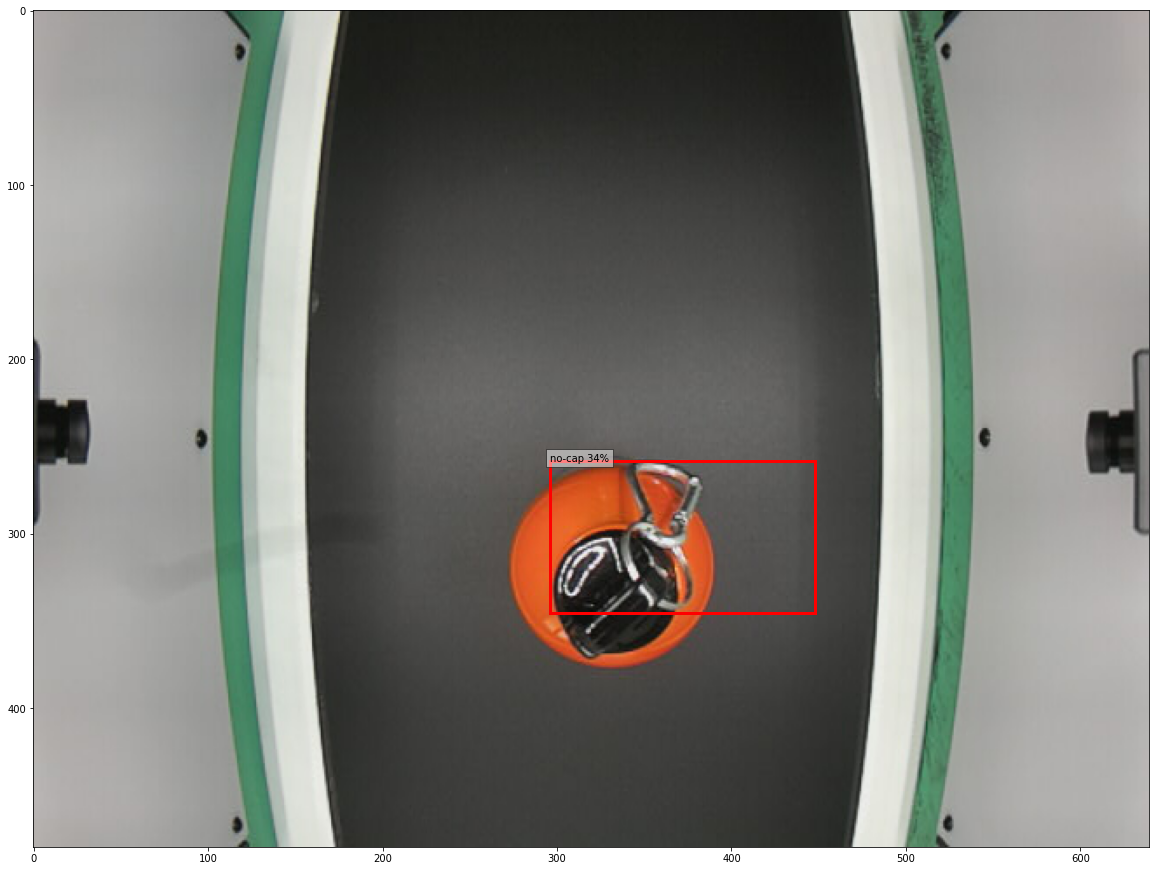

In [132]:
import random

sample_imgs_dir = "tmp/data/cam1"
sample_imgs = os.listdir(sample_imgs_dir)

bottle_image_file_name = random.choice(sample_imgs)


bottle_image_file_name = os.path.join(sample_imgs_dir, bottle_image_file_name)

# bottle_image_file_name = "tmp/guvcview_image-100.jpg"
print(bottle_image_file_name)

query_response = query(finetuned_predictor, bottle_image_file_name)

normalized_boxes, classes_names, confidences = parse_response(query_response)
print(normalized_boxes, classes_names, confidences)
classes_names = class_id_to_names(classes_names, categories_map)
display_predictions(bottle_image_file_name, normalized_boxes, classes_names, confidences)

Inspect the labeled data by visualizing the bounding boxes on the images to see if they surround the object of interest or not.

In [100]:
import json

with open("tmp/coco_annotations.json") as coco_annotations_path:
    coco_annotations = json.load(coco_annotations_path)

In [101]:
img_meta = {}

for curr_img in coco_annotations["images"]:
    if curr_img["file_name"] == image_filename_to_inspect:
        img_meta = curr_img

annotation_meta = []
for curr_annotation in coco_annotations["annotations"]:
    if curr_annotation["image_id"] == img_meta["id"]:
        annotation_meta.append(curr_annotation)        

In [102]:
img_meta, annotation_meta

({'id': 0,
  'file_name': 'guvcview_image-100.jpg',
  'width': 640,
  'height': 480,
  'depth': 3},
 [{'image_id': 0,
   'category_id': 0,
   'bbox': [0.43125, 0.375, 0.61875, 0.6083333333333333]}])

In [103]:
print(normalized_boxes, classes_names, confidences)

[[0.0, 0.530464768, 0.195601255, 0.714255571]] ['no-cap'] [0.109332293]


In [104]:
boxes = [annotation_meta[0]['bbox']]
classes_names = [annotation_meta[0]['category_id']]
confidences = [1]

In [105]:
image_filename_to_inspect

'guvcview_image-100.jpg'

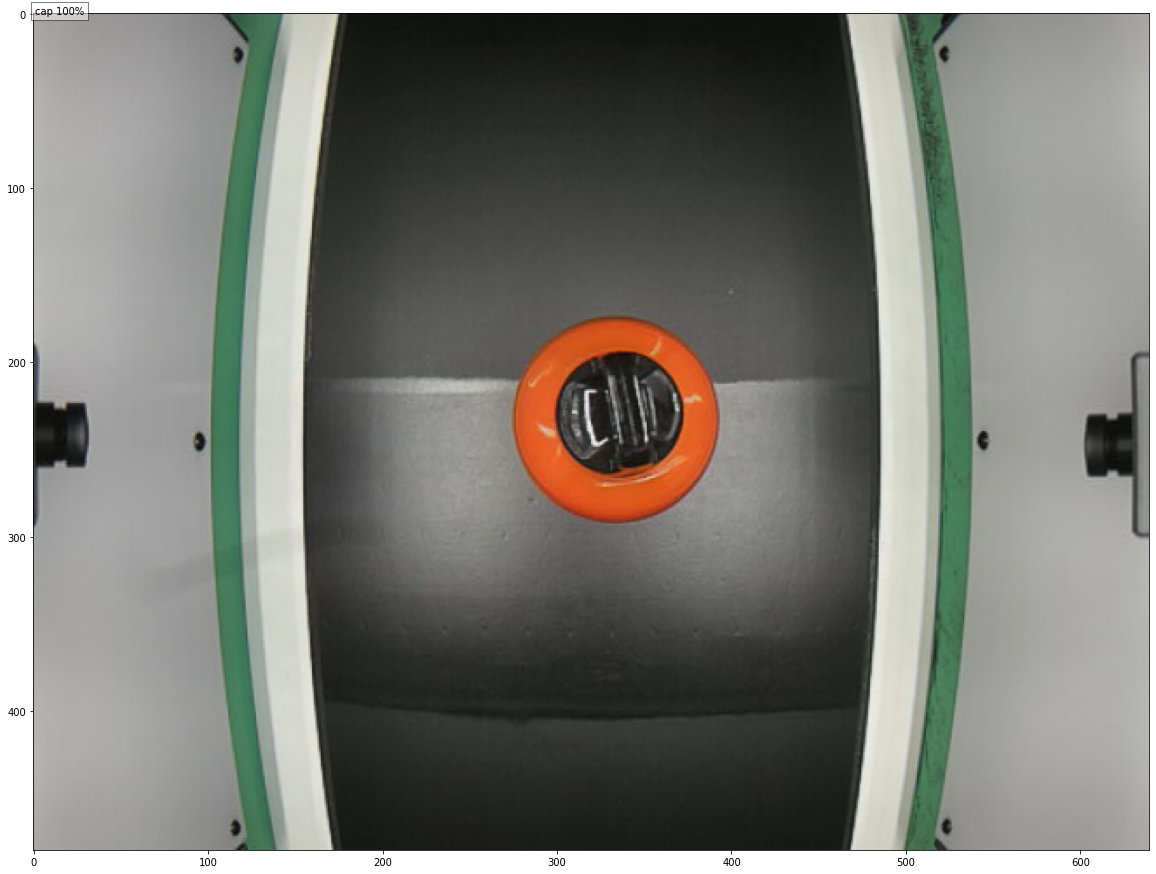

In [106]:
bottle_image_file_name = f"tmp/{image_filename_to_inspect}"
classes_names = class_id_to_names(classes_names, categories_map)
display_predictions(bottle_image_file_name, boxes, classes_names, confidences, normalize_bbox=True)

### Clean up

---
Next, we clean up the deployed endpoint.

---

In [113]:
# Delete the SageMaker endpoint and the attached resources
finetuned_predictor.delete_model()
finetuned_predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: sagemaker-jumpstart-2023-01-30-23-32-05-882
INFO:sagemaker:Deleting endpoint configuration with name: cv-bootcamp-cap-no-cap-FT-tensorflow-od-2023-01-30-23-32-05-882
INFO:sagemaker:Deleting endpoint with name: cv-bootcamp-cap-no-cap-FT-tensorflow-od-2023-01-30-23-32-05-882


## 4.7. Incrementally train the fine-tuned model

***
Incremental training allows you to train a new model using an expanded dataset that contains an underlying pattern that was not accounted for in the previous training and which resulted in poor model performance. You can use the artifacts from an existing model and use an expanded dataset to train a new model. Incremental training saves both time and resources as you don’t need to retrain a model from scratch.

One may use any dataset (old or new) as long as the dataset format remain the same (set of classes). Incremental training step is similar to the finetuning step discussed above with the following difference: In fine-tuning above, we start with a pre-trained model whereas in incremental training, we start with an existing fine-tuned model.
***

In [ ]:
# Identify the previously trained model path based on the output location where artifacts are stored previously and the training job name.

# if use_amt:  # If using amt, select the model for the best training job.
#     sage_client = boto3.Session().client("sagemaker")
#     tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(
#         HyperParameterTuningJobName=hp_tuner._current_job_name
#     )
#     last_training_job_name = tuning_job_result["BestTrainingJob"]["TrainingJobName"]
# else:
#     last_training_job_name = od_estimator._current_job_name

# last_trained_model_path = f"{s3_output_location}/{last_training_job_name}/output/model.tar.gz"

In [ ]:
# incremental_train_output_prefix = "jumpstart-example-ic-incremental-training"

# incremental_s3_output_location = f"s3://{output_bucket}/{incremental_train_output_prefix}/output"

# incremental_training_job_name = name_from_base(f"jumpstart-example-{model_id}-incremental-training")

# incremental_train_estimator = Estimator(
#     role=aws_role,
#     image_uri=train_image_uri,
#     source_dir=train_source_uri,
#     model_uri=last_trained_model_path,
#     entry_point="transfer_learning.py",
#     instance_count=1,
#     instance_type=training_instance_type,
#     max_run=360000,
#     hyperparameters=hyperparameters,
#     output_path=incremental_s3_output_location,
#     base_job_name=incremental_training_job_name,
#     metric_definitions=training_metric_definitions,
# )

# incremental_train_estimator.fit({"training": training_dataset_s3_path}, logs=True)

Once trained, we can use the same steps as in [Deploy & run Inference on the fine-tuned model](#4.6.-Deploy-&-run-Inference-on-the-fine-tuned-model) to deploy the model.